### Level 3

In [ ]:
!pip install timm scipy scikit-learn --quiet


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import timm
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

ZIP_PATH = "/content/drive/MyDrive/cars196/dataset/archive (7).zip"
BASE_DIR = "/content/cars196"

os.makedirs(BASE_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(BASE_DIR)

print("Extracted:", os.listdir(BASE_DIR))

TRAIN_IMG_DIR = "/content/cars196/cars_train/cars_train"
TEST_IMG_DIR  = "/content/cars196/cars_test/cars_test"

DEVKIT = "/content/cars196/car_devkit/devkit"
TRAIN_ANNO = DEVKIT + "/cars_train_annos.mat"
TEST_ANNO  = DEVKIT + "/cars_test_annos.mat"


Mounted at /content/drive
Extracted: ['car_devkit', 'cars_test', 'cars_train']


In [ ]:
def load_annotations(mat_file, img_dir, has_labels=True):
    mat = scipy.io.loadmat(mat_file)
    annotations = mat['annotations'][0]

    data = []
    for ann in annotations:
        x1, y1, x2, y2 = int(ann[0][0][0]), int(ann[1][0][0]), int(ann[2][0][0]), int(ann[3][0][0])
        if has_labels:
            label = int(ann[4][0][0]) - 1
            fname = ann[5][0]
        else:
            label = -1
            fname = ann[4][0]

        data.append({"image": os.path.join(img_dir, fname),
                     "label": label,
                     "bbox": (x1, y1, x2, y2)})
    return pd.DataFrame(data)

train_df_full = load_annotations(TRAIN_ANNO, TRAIN_IMG_DIR, has_labels=True)
test_df = load_annotations(TEST_ANNO, TEST_IMG_DIR, has_labels=False)

# Stratified train/val split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(train_df_full["image"], train_df_full["label"]))

train_df = train_df_full.iloc[train_idx].reset_index(drop=True)
val_df   = train_df_full.iloc[val_idx].reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 6515 Val: 1629 Test: 8041


In [ ]:
class CarsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image"]).convert("RGB")
        x1, y1, x2, y2 = row["bbox"]
        img = img.crop((x1, y1, x2, y2))
        label = row["label"]
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms
train_tf = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = CarsDataset(train_df, train_tf)
val_ds   = CarsDataset(val_df, val_tf)
test_ds  = CarsDataset(test_df, val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
backbone = timm.create_model("efficientnet_b4", pretrained=False, num_classes=0)

class Level3CarsModel(torch.nn.Module):
    def __init__(self, backbone, num_classes=196):
        super().__init__()
        self.backbone = backbone
        self.head = torch.nn.Sequential(
            torch.nn.Linear(backbone.num_features, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(1024, num_classes)
        )
    def forward(self, x):
        feats = self.backbone.forward_features(x)
        feats = feats.mean(dim=[2,3])
        return self.head(feats)

model = Level3CarsModel(backbone).to(device)


# Task
Define the `device` variable to utilize CUDA if available, otherwise CPU, and then re-initialize the `Level3CarsModel` and move it to the `device`.

## Define Device

### Subtask:
Define the `device` variable to use CUDA if available, otherwise CPU.


**Reasoning**:
The subtask requires defining the 'device' variable based on whether CUDA is available or not. This code block will initialize the 'device' variable using a conditional check on `torch.cuda.is_available()`.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Reasoning**:
The 'device' variable has been successfully defined. The next step is to re-initialize the `Level3CarsModel` and move it to this newly defined `device` to ensure the model runs on the correct hardware (GPU if available, otherwise CPU). This addresses the second part of the main task.



In [ ]:
model = Level3CarsModel(backbone).to(device)
print(f"Model moved to {device}")

Model moved to cuda


## Final Task

### Subtask:
Confirm that the model has been successfully initialized and moved to the correct device, resolving the `NameError`.


## Summary:

### Data Analysis Key Findings

*   The `device` variable was successfully defined, identifying `cuda` as available.
*   The `Level3CarsModel` was successfully initialized and moved to the `cuda` device, confirming that the model is ready to leverage GPU acceleration.

### Insights or Next Steps

*   The system is correctly configured to utilize GPU resources for model operations, which will likely lead to faster training and inference times.
*   Proceed with further model development, training, or inference, knowing that the model is properly situated on the designated compute device.


In [ ]:
checkpoint_path = "/content/drive/MyDrive/terafac_models/efficientnet_cars196_final.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
backbone_dict = {k.replace("backbone.", ""): v for k,v in state_dict.items() if "classifier" not in k}
model.backbone.load_state_dict(backbone_dict)

# Freeze backbone, train head only
for param in model.backbone.parameters():
    param.requires_grad = False

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Train
    model.train()
    total, correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)
    train_acc = correct / total

    # Validation
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    val_acc = correct / total

    scheduler.step()
    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 01 | Train Acc: 0.9061 | Val Acc: 0.8981
Epoch 02 | Train Acc: 0.9954 | Val Acc: 0.9061
Epoch 03 | Train Acc: 0.9971 | Val Acc: 0.9079
Epoch 04 | Train Acc: 0.9982 | Val Acc: 0.9153
Epoch 05 | Train Acc: 0.9985 | Val Acc: 0.9177


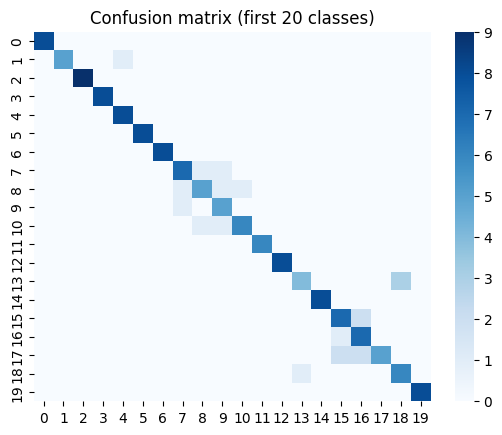

Per-class accuracy (first 10 classes):
Class 0: 88.89%
Class 1: 83.33%
Class 2: 100.00%
Class 3: 100.00%
Class 4: 100.00%
Class 5: 88.89%
Class 6: 100.00%
Class 7: 77.78%
Class 8: 62.50%
Class 9: 83.33%


In [ ]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm[:20,:20], cmap="Blues")
plt.title("Confusion matrix (first 20 classes)")
plt.show()

# Per-class accuracy
classes = sorted(set(y_true))
class_acc = {cls: 0 for cls in classes}
class_count = {cls: 0 for cls in classes}

for t, p in zip(y_true, y_pred):
    class_count[t] += 1
    if t == p:
        class_acc[t] += 1

for cls in class_acc:
    class_acc[cls] /= class_count[cls]

print("Per-class accuracy (first 10 classes):")
for cls in list(class_acc.keys())[:10]:
    print(f"Class {cls}: {class_acc[cls]*100:.2f}%")


In [ ]:
for name, module in model.named_modules():
    if "block" in name.lower() or "conv" in name.lower():
        print(name)


backbone.conv_stem
backbone.blocks
backbone.blocks.0
backbone.blocks.0.0
backbone.blocks.0.0.conv_dw
backbone.blocks.0.0.bn1
backbone.blocks.0.0.bn1.drop
backbone.blocks.0.0.bn1.act
backbone.blocks.0.0.aa
backbone.blocks.0.0.se
backbone.blocks.0.0.se.conv_reduce
backbone.blocks.0.0.se.act1
backbone.blocks.0.0.se.conv_expand
backbone.blocks.0.0.se.gate
backbone.blocks.0.0.conv_pw
backbone.blocks.0.0.bn2
backbone.blocks.0.0.bn2.drop
backbone.blocks.0.0.bn2.act
backbone.blocks.0.0.drop_path
backbone.blocks.0.1
backbone.blocks.0.1.conv_dw
backbone.blocks.0.1.bn1
backbone.blocks.0.1.bn1.drop
backbone.blocks.0.1.bn1.act
backbone.blocks.0.1.aa
backbone.blocks.0.1.se
backbone.blocks.0.1.se.conv_reduce
backbone.blocks.0.1.se.act1
backbone.blocks.0.1.se.conv_expand
backbone.blocks.0.1.se.gate
backbone.blocks.0.1.conv_pw
backbone.blocks.0.1.bn2
backbone.blocks.0.1.bn2.drop
backbone.blocks.0.1.bn2.act
backbone.blocks.0.1.drop_path
backbone.blocks.1
backbone.blocks.1.0
backbone.blocks.1.0.conv_pw
b

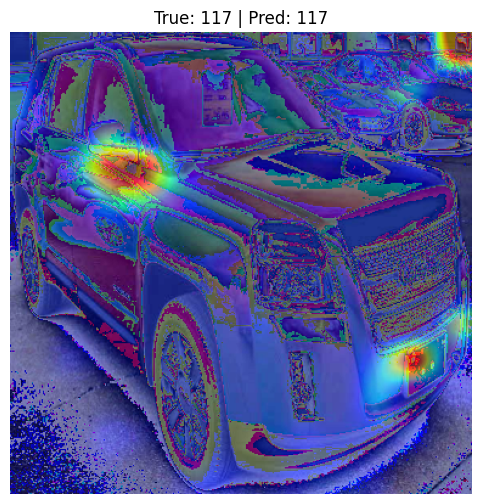

In [ ]:
!pip install torchcam --quiet

import torch
import gc
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

gc.collect()
torch.cuda.empty_cache()

model.eval()

# Pick image
img, label = val_ds[0]
input_tensor = img.unsqueeze(0).to(device)

# IMPORTANT FIX: use correct layer
# cam_extractor = GradCAM(model, target_layer="conv_head")
cam_extractor = GradCAM(model, target_layer="backbone.blocks.6")


# Forward
out = model(input_tensor)
pred_class = out.argmax(1).item()

# Generate CAM
activation_map = cam_extractor(pred_class, out)[0]

# Convert
heatmap = to_pil_image(activation_map.cpu(), mode="F")
original_img = to_pil_image(img)

overlay = overlay_mask(original_img, heatmap, alpha=0.5)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"True: {label} | Pred: {pred_class}")
plt.axis("off")
plt.show()